# Quickly solving Kepler's Problem in Python using numba

## Introduction

*In this notebook we will prove how using **numba** we can achieve almost native performance using solely the Python programming language. We will implement an algorithm to solve Kepler's problem running a standard Newton-Raphson iteration on the Kepler's equation, hence following the approach of Bate & Mueller and Vallado. We will run benchmarks against the Vallado Fortran version, available on the Internet and wrapped in poliastro 0.2.*

**Author**: Juan Luis Cano Rodríguez <juanlu@pybonacci.org> (<a href="http://es.linkedin.com/in/juanluiscanor/en">LinkedIn</a>)

<div class="alert alert-info">For executing this notebook you will need to use the branch `idea-numba` of the poliastro repository: https://github.com/Pybonacci/poliastro/tree/idea-numba</div>

## Fortran version

In [1]:
import numpy as np
from astropy import units as u

from poliastro.bodies import Earth
from poliastro.twobody import State, propagation

In [2]:
k = Earth.k
r0 = [1131.340, -2282.343, 6672.423] * u.km
v0 = [-5.64305, 4.30333, 2.42879] * u.km / u.s
tof = 40 * u.min

In [3]:
r0

<Quantity [ 1131.34 ,-2282.343, 6672.423] km>

In [4]:
v0

<Quantity [-5.64305, 4.30333, 2.42879] km / s>

In [5]:
k

<Quantity 398600.0 km3 / s2>

In [6]:
tof

<Quantity 40.0 min>

In [7]:
r, v = propagation.kepler(k.to(u.km**3 / u.s**2).value,
                          r0.to(u.km).value,
                          v0.to(u.km / u.s).value,
                          tof.to(u.s).value)
r *= u.km
v *= u.km / u.s

In [8]:
r

<Quantity [-4219.77617109, 4363.04569716,-3958.74972246] km>

In [9]:
v

<Quantity [ 3.68983773,-1.91670933,-6.11251847] km / s>

Prepare the inputs to measure performance:

In [10]:
k_ = k.to(u.km**3 / u.s**2).value
r0_ = r0.to(u.km).value
v0_ = v0.to(u.km / u.s).value
tof_ = tof.to(u.s).value

In [11]:
%timeit propagation.kepler(k_, r0_, v0_, tof_)

The slowest run took 9.87 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 10.5 µs per loop


## Pure Python version

Now we write our own implementation in pure Python. We will use numbified $c_2$ and $c_3$ functions for the moment.

In [12]:
from poliastro.stumpff import c2, c3

def kepler_py(k, r0, v0, tof):
    # Prepare input
    r0 = np.asarray(r0).astype(np.float)
    v0 = np.asarray(v0).astype(np.float)
    tof = float(tof)
    assert r0.shape == (3,)
    assert v0.shape == (3,)

    # Cache some results
    dot_r0v0 = np.dot(r0, v0)
    norm_r0 = np.linalg.norm(r0)
    sqrt_mu = np.sqrt(k)
    alpha = -np.dot(v0, v0) / k + 2 / norm_r0

    # Newton-Raphson iteration on the Kepler equation
    # Conservative initial guess
    xi = sqrt_mu * tof / norm_r0
    numiter = 50
    count = 0
    while count < numiter:
        psi = xi**2 * alpha
        norm_r = xi**2 * c2(psi) + dot_r0v0 / sqrt_mu * xi * (1 - psi * c3(psi)) + norm_r0 * (1 - psi * c2(psi))
        xi_new = xi + (sqrt_mu * tof - xi**3 * c3(psi) - dot_r0v0 / sqrt_mu * xi**2 * c2(psi) -
                       norm_r0 * xi * (1 - psi * c3(psi))) / norm_r
        err = np.abs((xi_new - xi) / xi_new)
        if err < 1e-10:
            break
        else:
            xi = xi_new
            count += 1
    else:
        print("No convergence")
        return

    # Compute Lagrange coefficients
    f = 1 - xi**2 / norm_r0 * c2(psi)
    g = tof - xi**3 / sqrt_mu * c3(psi)

    gdot = 1 - xi**2 / norm_r * c2(psi)
    fdot = sqrt_mu / (norm_r * norm_r0) * xi * (psi * c3(psi) - 1)

    # Return position and velocity vectors
    r = f * r0 + g * v0
    v = fdot * r0 + gdot * v0

    assert np.abs(f * gdot - fdot * g - 1) < 1e-6

    return r, v

In [13]:
r_py, v_py = kepler_py(k_, r0_, v0_, tof_)
r_py *= u.km
v_py *= u.km / u.s

In [14]:
np.testing.assert_array_almost_equal(r_py.value, r.value)
np.testing.assert_array_almost_equal(v_py.value, v.value)

In [15]:
r_py

<Quantity [-4219.77617109, 4363.04569716,-3958.74972246] km>

In [16]:
%timeit kepler_py(k_, r0_, v0_, tof_)

The slowest run took 7.80 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 69.9 µs per loop


In [17]:
%timeit propagation.kepler(k_, r0_, v0_, tof_)

100000 loops, best of 3: 11 µs per loop


Our pure Python, non optimized version **is not *that* bad**! It stays in the same order of magnitude as the Fortran version for elliptic orbits at least. Let us see how can we improve the results.

In [18]:
%load_ext line_profiler

In [19]:
%lprun -f kepler_py kepler_py(k_, r0_, v0_, tof_)

According to line_profiler, 13 % of the time is spent in the two `asarray` calls and 14.5 % in the single `norm` computation.

In [20]:
%timeit np.linalg.norm(r0_)

The slowest run took 13.55 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 7.96 µs per loop


In [21]:
%timeit np.sqrt(np.dot(r0_, r0_))

The slowest run took 14.04 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.23 µs per loop


We can try and replace `linalg.norm` with the square root of the dot product. We can go further and assume the input are float arrays to save some more microseconds.

In [22]:
def kepler_py2(k, r0, v0, tof):
    # Algorithm parameters
    rtol = 1e-10
    numiter = 50
    
    # Cache some results
    dot_r0v0 = np.dot(r0, v0)
    norm_r0 = np.sqrt(np.dot(r0, r0))
    sqrt_mu = np.sqrt(k)
    alpha = -np.dot(v0, v0) / k + 2 / norm_r0

    # Newton-Raphson iteration on the Kepler equation
    # Conservative initial guess
    xi = sqrt_mu * tof / norm_r0
    count = 0
    while count < numiter:
        psi = xi * xi * alpha
        c2_psi = c2(psi)
        c3_psi = c3(psi)
        norm_r = xi * xi * c2_psi + dot_r0v0 / sqrt_mu * xi * (1 - psi * c3_psi) + norm_r0 * (1 - psi * c2_psi)
        xi_new = xi + (sqrt_mu * tof - xi * xi * xi * c3_psi - dot_r0v0 / sqrt_mu * xi * xi * c2_psi -
                       norm_r0 * xi * (1 - psi * c3_psi)) / norm_r
        if abs((xi_new - xi) / xi_new) < rtol:
            break
        else:
            xi = xi_new
            count += 1
    else:
        raise RuntimeError("Convergence could not be achieved under "
                           "%d iterations" % numiter)

    # Compute Lagrange coefficients
    f = 1 - xi**2 / norm_r0 * c2_psi
    g = tof - xi**3 / sqrt_mu * c3_psi

    gdot = 1 - xi**2 / norm_r * c2_psi
    fdot = sqrt_mu / (norm_r * norm_r0) * xi * (psi * c3_psi - 1)

    # Return position and velocity vectors
    r = f * r0 + g * v0
    v = fdot * r0 + gdot * v0

    assert np.abs(f * gdot - fdot * g - 1) < rtol

    return r, v

In [23]:
r_py2, v_py2 = kepler_py2(k_, r0_, v0_, tof_)
r_py2 *= u.km
v_py2 *= u.km / u.s

In [24]:
np.testing.assert_array_almost_equal(r_py2.value, r.value)
np.testing.assert_array_almost_equal(v_py2.value, v.value)

In [25]:
%timeit kepler_py2(k_, r0_, v0_, tof_)

10000 loops, best of 3: 36.1 µs per loop


## Optimized Python + numba version

We cut the time in half! We still have another bullet: numba. This will require some work though, because we will have to provide some work arrays from outside to use the functions `np.abs` and `np.dot`, and in particular the latest one is not available. On the other hand, we will have to provide a better initial guess to achieve reasonable speed for hyperbolic orbits too.

In [26]:
import numba

def kepler_numba(k, r0, v0, tof, numiter=35, rtol=1e-10):
    """Propagates Keplerian orbit.

    Parameters
    ----------
    k : float
        Gravitational constant of main attractor (km^3 / s^2).
    r0 : array
        Initial position (km).
    v0 : array
        Initial velocity (km).
    tof : float
        Time of flight (s).
    numiter : int, optional
        Maximum number of iterations, default to 35.
    rtol : float, optional
        Maximum relative error permitted, default to 1e-10.

    Raises
    ------
    RuntimeError
        If the algorithm didn't converge.

    Notes
    -----
    This algorithm is based on Vallado implementation, and does basic Newton
    iteration on the Kepler equation written using universal variables. Battin
    claims his algorithm uses the same amount of memory but is between 40 %
    and 85 % faster.

    """
    # Compute Lagrange coefficients
    try:
        f, g, fdot, gdot = _kepler(k, r0, v0, tof, numiter, rtol)
    except RuntimeError:
        raise RuntimeError("Convergence could not be achieved under "
                           "%d iterations" % numiter)

    assert np.abs(f * gdot - fdot * g - 1) < 1e-5  # Fixed tolerance

    # Return position and velocity vectors
    r = f * r0 + g * v0
    v = fdot * r0 + gdot * v0

    return r, v

@numba.njit('f8(f8[:], f8[:])')
def dot(u, v):
    dp = 0.0
    for ii in range(u.shape[0]):
        dp += u[ii] * v[ii]
    return dp

@numba.njit
def _kepler(k, r0, v0, tof, numiter, rtol):
    # Cache some results
    dot_r0v0 = dot(r0, v0)
    norm_r0 = dot(r0, r0) ** .5
    sqrt_mu = k**.5
    alpha = -dot(v0, v0) / k + 2 / norm_r0

    # First guess
    if alpha > 0:
        # Elliptic orbit
        xi_new = sqrt_mu * tof * alpha
    elif alpha < 0:
        # Hyperbolic orbit
        xi_new = (np.sign(tof) * (-1 / alpha)**.5 *
                  np.log((-2 * k * alpha * tof) / (dot_r0v0 + np.sign(tof) * np.sqrt(-k / alpha) * (1 - norm_r0 * alpha))))

    # Newton-Raphson iteration on the Kepler equation
    count = 0
    while count < numiter:
        xi = xi_new
        psi = xi * xi * alpha
        c2_psi = c2(psi)
        c3_psi = c3(psi)
        norm_r = xi * xi * c2_psi + dot_r0v0 / sqrt_mu * xi * (1 - psi * c3_psi) + norm_r0 * (1 - psi * c2_psi)
        xi_new = xi + (sqrt_mu * tof - xi * xi * xi * c3_psi - dot_r0v0 / sqrt_mu * xi * xi * c2_psi -
                       norm_r0 * xi * (1 - psi * c3_psi)) / norm_r
        if abs((xi_new - xi) / xi_new) < rtol:
            break
        else:
            count += 1
    else:
        raise RuntimeError

    # Compute Lagrange coefficients
    f = 1 - xi**2 / norm_r0 * c2_psi
    g = tof - xi**3 / sqrt_mu * c3_psi

    gdot = 1 - xi**2 / norm_r * c2_psi
    fdot = sqrt_mu / (norm_r * norm_r0) * xi * (psi * c3_psi - 1)

    return f, g, fdot, gdot

And we provide a Python version of the final function for benchmarking too:

In [39]:
def kepler_python_final(k, r0, v0, tof, numiter=35, rtol=1e-10):
    # Cache some results
    dot_r0v0 = np.dot(r0, v0)
    norm_r0 = np.dot(r0, r0) ** .5
    sqrt_mu = k**.5
    alpha = -np.dot(v0, v0) / k + 2 / norm_r0

    # First guess
    if alpha > 0:
        # Elliptic orbit
        xi_new = sqrt_mu * tof * alpha
    elif alpha < 0:
        # Hyperbolic orbit
        xi_new = (np.sign(tof) * (-1 / alpha)**.5 *
                  np.log((-2 * k * alpha * tof) / (dot_r0v0 + np.sign(tof) * np.sqrt(-k / alpha) * (1 - norm_r0 * alpha))))

    # Newton-Raphson iteration on the Kepler equation
    count = 0
    while count < numiter:
        xi = xi_new
        psi = xi * xi * alpha
        c2_psi = c2(psi)
        c3_psi = c3(psi)
        norm_r = xi * xi * c2_psi + dot_r0v0 / sqrt_mu * xi * (1 - psi * c3_psi) + norm_r0 * (1 - psi * c2_psi)
        xi_new = xi + (sqrt_mu * tof - xi * xi * xi * c3_psi - dot_r0v0 / sqrt_mu * xi * xi * c2_psi -
                       norm_r0 * xi * (1 - psi * c3_psi)) / norm_r
        if abs((xi_new - xi) / xi_new) < rtol:
            break
        else:
            count += 1
    else:
        raise RuntimeError("Convergence could not be achieved under "
                           "%d iterations" % numiter)

    # Compute Lagrange coefficients
    f = 1 - xi**2 / norm_r0 * c2_psi
    g = tof - xi**3 / sqrt_mu * c3_psi

    gdot = 1 - xi**2 / norm_r * c2_psi
    fdot = sqrt_mu / (norm_r * norm_r0) * xi * (psi * c3_psi - 1)

    assert np.abs(f * gdot - fdot * g - 1) < 1e-5  # Fixed tolerance

    # Return position and velocity vectors
    r = f * r0 + g * v0
    v = fdot * r0 + gdot * v0

    return r, v

In [27]:
r_numba, v_numba = kepler_numba(k_, r0_, v0_, tof_)
r_numba *= u.km
v_numba *= u.km / u.s

In [28]:
np.testing.assert_array_almost_equal(r_numba.value, r.value)
np.testing.assert_array_almost_equal(v_numba.value, v.value)

In [29]:
r_numba

<Quantity [-4219.77617109, 4363.04569716,-3958.74972246] km>

In [30]:
v_numba

<Quantity [ 3.68983773,-1.91670933,-6.11251847] km / s>

In [31]:
%timeit kepler_numba(k_, r0_, v0_, tof_)

The slowest run took 11.71 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11.9 µs per loop


**We achieved a 0.9x factor with the pure Python version**: the results are promising!

## Benchmark

We will cover a range of values of eccentricity to compare both versions, plotting computation time vs time of flight.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

In [33]:
from poliastro.twobody import State
from poliastro.plotting import plot

### Elliptic orbit

[  2400.           5531.82615614   8663.65231228  11795.47846841
  14927.30462455  18059.13078069  21190.95693683  24322.78309297]


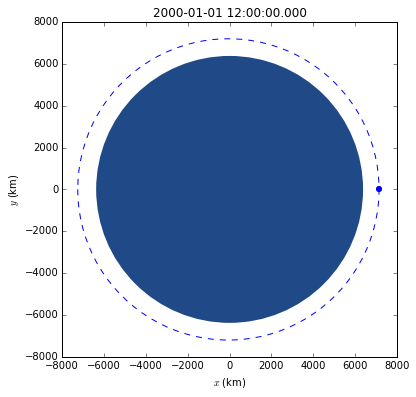

In [34]:
ss = State.from_vectors(Earth, r0, v0)
tof_range = np.linspace(tof.to(u.s).value,
                        (ss.period * 4).to(u.s).value,
                        num=8)
print(tof_range)
plot(ss)

In [42]:
res_fortran = []
res_numba = []
res_python = []
for tof_ in tof_range:
    timeit_res_fortran = %timeit -o propagation.kepler(k_, r0_, v0_, tof_)
    timeit_res_numba = %timeit -o kepler_numba(k_, r0_, v0_, tof_)
    timeit_res_python = %timeit -o kepler_python_final(k_, r0_, v0_, tof_)
    res_fortran.append(timeit_res_fortran.best)
    res_numba.append(timeit_res_numba.best)
    res_python.append(timeit_res_python.best)

The slowest run took 4.69 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11 µs per loop
100000 loops, best of 3: 12.7 µs per loop
10000 loops, best of 3: 33.8 µs per loop
100000 loops, best of 3: 10.8 µs per loop
100000 loops, best of 3: 12.5 µs per loop
10000 loops, best of 3: 34 µs per loop
100000 loops, best of 3: 11 µs per loop
100000 loops, best of 3: 12.8 µs per loop
10000 loops, best of 3: 34.9 µs per loop
100000 loops, best of 3: 10.9 µs per loop
The slowest run took 4.11 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.5 µs per loop
10000 loops, best of 3: 34.1 µs per loop
100000 loops, best of 3: 10.9 µs per loop
The slowest run took 4.05 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.5 µs per loop
10000 loops, best of 3: 33.9 µs per loop
100000 loops, best of 3: 10

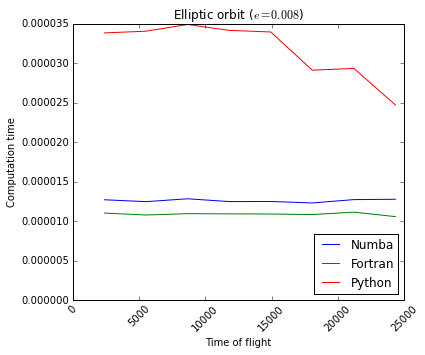

In [43]:
plt.figure(figsize=(6, 5))
plt.plot(tof_range, res_numba, label="Numba")
plt.plot(tof_range, res_fortran, label="Fortran")
plt.plot(tof_range, res_python, label="Python")
plt.legend(loc=4)
plt.ylim(0)
plt.xlabel("Time of flight")
plt.xticks(rotation=45)
plt.ylabel("Computation time")
plt.title("Elliptic orbit ($e = {:.3f}$)".format(ss.ecc))
plt.tight_layout()

### Moderate eccentricity elliptic orbit

[  2400.           7038.06111541  11676.12223083  16314.18334624
  20952.24446165  25590.30557707  30228.36669248  34866.42780789]


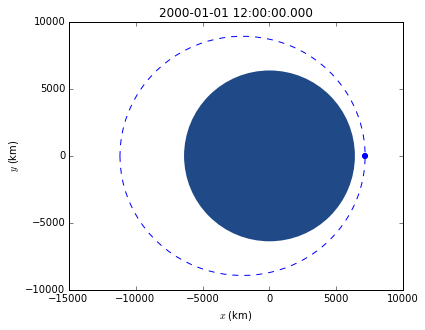

In [44]:
ss = State.from_vectors(Earth, r0, v0 * 1.1)
tof_range = np.linspace(tof.to(u.s).value,
                        (ss.period * 4).to(u.s).value,
                        num=8)
print(tof_range)
plot(ss)

In [45]:
res_fortran = []
res_numba = []
res_python = []
r0_ = ss.r.to(u.km).value
v0_ = ss.v.to(u.km / u.s).value
for tof_ in tof_range:
    timeit_res_fortran = %timeit -o propagation.kepler(k_, r0_, v0_, tof_)
    timeit_res_numba = %timeit -o kepler_numba(k_, r0_, v0_, tof_)
    timeit_res_python = %timeit -o kepler_python_final(k_, r0_, v0_, tof_)
    res_fortran.append(timeit_res_fortran.best)
    res_numba.append(timeit_res_numba.best)
    res_python.append(timeit_res_python.best)

100000 loops, best of 3: 10.8 µs per loop
100000 loops, best of 3: 12.7 µs per loop
10000 loops, best of 3: 40.8 µs per loop
100000 loops, best of 3: 10.7 µs per loop
The slowest run took 4.14 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.6 µs per loop
10000 loops, best of 3: 41 µs per loop
100000 loops, best of 3: 10.9 µs per loop
The slowest run took 4.67 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.7 µs per loop
10000 loops, best of 3: 39.2 µs per loop
100000 loops, best of 3: 11.2 µs per loop
The slowest run took 7.44 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.7 µs per loop
10000 loops, best of 3: 41.1 µs per loop
100000 loops, best of 3: 11.2 µs per loop
The slowest run took 4.08 times longer than the fastest. This could mean that an intermediate result is be

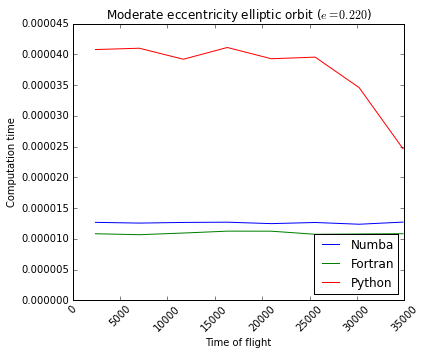

In [47]:
plt.figure(figsize=(6, 5))
plt.plot(tof_range, res_numba, label="Numba")
plt.plot(tof_range, res_fortran, label="Fortran")
plt.plot(tof_range, res_python, label="Python")
plt.legend(loc=4)
plt.ylim(0)
plt.xlabel("Time of flight")
plt.xticks(rotation=45)
plt.ylabel("Computation time")
plt.title("Moderate eccentricity elliptic orbit ($e = {:.3f}$)".format(ss.ecc))
plt.tight_layout()

### Near-parabolic orbit

[   2400.           77662.41861854  152924.83723708  228187.25585562
  303449.67447416  378712.0930927   453974.51171124  529236.93032979]


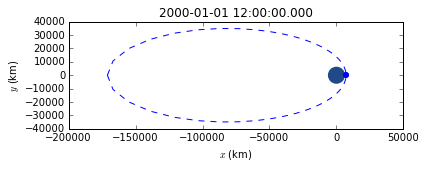

In [61]:
ss = State.from_vectors(Earth, r0, v0 * 1.38)
tof_range = np.linspace(tof.to(u.s).value,
                        (ss.period * 2).to(u.s).value,
                        num=8)
print(tof_range)
plot(ss)

In [62]:
res_fortran = []
res_numba = []
res_python = []
r0_ = ss.r.to(u.km).value
v0_ = ss.v.to(u.km / u.s).value
for tof_ in tof_range:
    timeit_res_fortran = %timeit -o propagation.kepler(k_, r0_, v0_, tof_)
    timeit_res_numba = %timeit -o kepler_numba(k_, r0_, v0_, tof_)
    timeit_res_python = %timeit -o kepler_python_final(k_, r0_, v0_, tof_)
    res_fortran.append(timeit_res_fortran.best)
    res_numba.append(timeit_res_numba.best)
    res_python.append(timeit_res_python.best)

The slowest run took 4.29 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11.3 µs per loop
100000 loops, best of 3: 18.7 µs per loop
10000 loops, best of 3: 55.6 µs per loop
100000 loops, best of 3: 11 µs per loop
The slowest run took 6.14 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 13 µs per loop
10000 loops, best of 3: 44.6 µs per loop
100000 loops, best of 3: 11 µs per loop
The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.5 µs per loop
10000 loops, best of 3: 39.6 µs per loop
100000 loops, best of 3: 11.3 µs per loop
The slowest run took 4.20 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 13 µs per loop
10000 loops, best of 3: 48.9 µs per loop
100000 loops, best of 3: 11.3 µs per

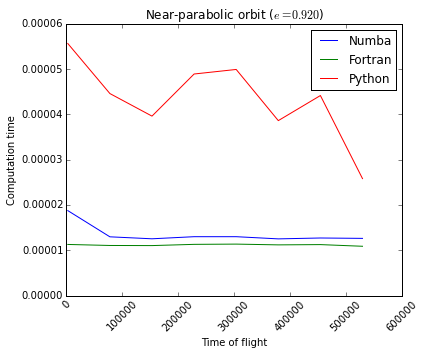

In [63]:
plt.figure(figsize=(6, 5))
plt.plot(tof_range, res_numba, label="Numba")
plt.plot(tof_range, res_fortran, label="Fortran")
plt.plot(tof_range, res_python, label="Python")
plt.legend()
plt.ylim(0)
plt.xlabel("Time of flight")
plt.xticks(rotation=45)
plt.ylabel("Computation time")
plt.title("Near-parabolic orbit ($e = {:.3f}$)".format(ss.ecc))
plt.tight_layout()

### Hyperbolic orbit

[   2400.           36342.85714286   70285.71428571  104228.57142857
  138171.42857143  172114.28571429  206057.14285714  240000.        ]


(array([-25000., -20000., -15000., -10000.,  -5000.,      0.,   5000.,
         10000.]), <a list of 8 Text xticklabel objects>)

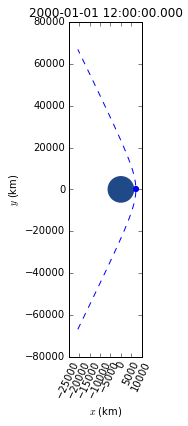

In [60]:
ss = State.from_vectors(Earth, r0, v0 * 1.8)
tof_range = np.linspace(tof.to(u.s).value,
                        100 * tof.to(u.s).value,
                        num=8)
print(tof_range)
plot(ss)
plt.xticks(rotation=65)

In [54]:
res_fortran = []
res_numba = []
res_python = []
r0_ = ss.r.to(u.km).value
v0_ = ss.v.to(u.km / u.s).value
for tof_ in tof_range:
    timeit_res_fortran = %timeit -o propagation.kepler(k_, r0_, v0_, tof_)
    timeit_res_numba = %timeit -o kepler_numba(k_, r0_, v0_, tof_, numiter=1000)
    timeit_res_python = %timeit -o kepler_python_final(k_, r0_, v0_, tof_)
    res_fortran.append(timeit_res_fortran.best)
    res_numba.append(timeit_res_numba.best)
    res_python.append(timeit_res_python.best)

100000 loops, best of 3: 12.1 µs per loop
100000 loops, best of 3: 13.3 µs per loop
10000 loops, best of 3: 56.5 µs per loop
100000 loops, best of 3: 11.7 µs per loop
100000 loops, best of 3: 12.9 µs per loop
10000 loops, best of 3: 47.1 µs per loop
100000 loops, best of 3: 11.9 µs per loop
100000 loops, best of 3: 13 µs per loop
10000 loops, best of 3: 46.8 µs per loop
100000 loops, best of 3: 11.6 µs per loop
The slowest run took 4.02 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 12.8 µs per loop
10000 loops, best of 3: 47.1 µs per loop
The slowest run took 6.14 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 11.5 µs per loop
100000 loops, best of 3: 13.2 µs per loop
10000 loops, best of 3: 48.5 µs per loop
100000 loops, best of 3: 11.9 µs per loop
The slowest run took 4.28 times longer than the fastest. This could mean that an intermediate resul

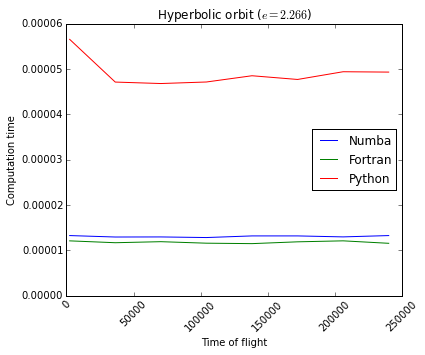

In [56]:
plt.figure(figsize=(6, 5))
plt.plot(tof_range, res_numba, label="Numba")
plt.plot(tof_range, res_fortran, label="Fortran")
plt.plot(tof_range, res_python, label="Python")
plt.legend(loc=5)
plt.ylim(0)
plt.xlabel("Time of flight")
plt.xticks(rotation=45)
plt.ylabel("Computation time")
plt.title("Hyperbolic orbit ($e = {:.3f}$)".format(ss.ecc))
plt.tight_layout()

<div class="alert alert-success"><strong>Conclusion</strong>: I can achieve 90 % of Fortran speed with pure Python using a JIT compiler like numba. This allows me not only to quickly prototype algorithms and iterate fast between versions, while obtaining excellent performance, unseen in a dynamic language like Python.</div>